# First look at the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [2]:
comments = pd.read_csv("../toxic_comment_data/sample_submission_null.csv")
# comments2 = pd.read_csv("../toxic_comment_data/test_with_solutions.csv")
# comments2 = comments2.drop(columns=["Usage"])
# comments = pd.concat([comments,comments2])

**Here we examine the training data (labeled with whether something is an insult or not). Some charming people.**

In [3]:
print("Rows: " + str(comments.shape[0]))
print("Columns: " + str(comments.shape[1]))
print("Number of insulting comments: " + str(len(comments[comments['Insult'] == 1])))
print("Number of non-insulting comments: " + str(len(comments[comments['Insult'] == 0])))
print("Number of comments missing dates: " + str(comments.isnull().sum().Date))

comments[0:10]

Rows: 2647
Columns: 3
Number of insulting comments: 0
Number of non-insulting comments: 2647
Number of comments missing dates: 524


,Insult,Date,Comment
0,0,NaN,"""THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th..."
1,0,20120618222256Z,"""@ian21\xa0""Roger Clemens is the fucking man, ..."
2,0,20120618213617Z,"""Agree with Alan you are an extremest idiot. ..."
3,0,NaN,"""Really?\\n\\nI see Marc Lamont Hill on variou..."
4,0,20120620003825Z,"""Really suck isn't the word, when many of our ..."
5,0,NaN,"""...after a couple guys like him rape him firs..."
6,0,20120529201500Z,"""Matthews mentored Perry at USC. Bodes well..."""
7,0,20120619145613Z,"""How about we accept facts and patiently wait ..."
8,0,20120609165037Z,"""To engage in an intelligent debate with you i..."
9,0,20120612145537Z,"""Same reason no one cared Obama did cocaine, w..."


**The comments are all unicode escaped, so inplace of special symbols there is some \escapeCode. It can be decoded if necessary as shown below.**

**Most of the data is english, but not all of it, not really a big deal though I suppose.**

In [4]:
sample_comment = comments.iloc[4].Comment
print(sample_comment)

"Really suck isn't the word, when many of our nuclear power plants start melting down, it will literally be hell on earth in the US and we have no one else to blame but our own CORRUPT GOVERNMENT!"


In [5]:
decoded_comment = bytes(sample_comment, 'ascii').decode('unicode-escape')
print(decoded_comment)

"Really suck isn't the word, when many of our nuclear power plants start melting down, it will literally be hell on earth in the US and we have no one else to blame but our own CORRUPT GOVERNMENT!"


**Lets add a column to the dataset that contains the length of every comment, we can use the built in method .str.len() from pandas, as opposed to doing something like len(x) where x is the comment string. This will deal with NaN cases automatically, were a string to not to be present for whatever reason. This also prevents a potential TypeError with standard len. **

_Note: this length measurement obviously includes all the unicode escape characters, so I also created a new column "True Length" which represents the length you would expect if it was printed normally. This utilizes the function below._

In [6]:
def true_length(input):
    if type(input) is str:
        return len(bytes(input, 'ascii').decode('unicode-escape'))
    else: 
        return -1 #arbitrary, should not ever happen with this dataset

In [7]:
comments['Raw_Length']  = comments['Comment'].str.len()
comments['True_Length'] = comments['Comment'].apply(lambda x: true_length(x))

comments[59:63]

,Insult,Date,Comment,Raw_Length,True_Length
59,0,NaN,"""Right now, we supposedly have a 2 party state...",3004,2921
60,0,20120528180228Z,"""bluz i agree, love the way he can handle the ...",75,75
61,0,20120611200109Z,"""Killing them should be a last resort, ""I'm go...",154,152
62,0,20120612014408Z,"""And continuing on route 59 all the way to Nue...",56,56


**Just wanted to try normalizing the length...**

In [8]:
col_max = comments['True_Length'].max()
col_min = comments['True_Length'].min()
comments['Norm_True_Length'] = comments['True_Length'].apply(lambda x: (x-col_min)/(col_max-col_min))
comments[75:78]

,Insult,Date,Comment,Raw_Length,True_Length,Norm_True_Length
75,0,20120619033759Z,"""@foxrock66 Why would you throw something like...",366,366,0.027351
76,0,20120611222308Z,"""If it's wrong to be ageist, why do we have a ...",73,73,0.005090
77,0,20120529211537Z,"""Would probably be cheaper just to legally cha...",61,61,0.004179


**Sanity check to verify that the min value has norm length 0, and max value has norm length 1:**

In [9]:
maxv = comments.iloc[comments['True_Length'].idxmax()].Norm_True_Length
minv = comments.iloc[comments['True_Length'].idxmin()].Norm_True_Length
print("Minimum length:",comments['True_Length'].min(),"      normalized:",minv)
print("Maximum length:",comments['True_Length'].max(),"  normalized:",maxv)

Minimum length: 6       normalized: 0.0
Maximum length: 13168   normalized: 1.0


# Comments

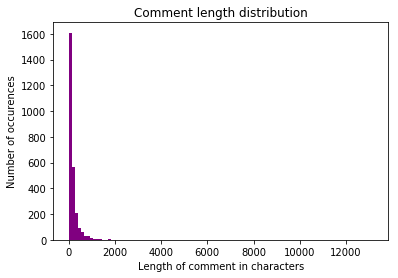

In [10]:
plt.hist(comments.True_Length,color="purple",bins=100)
plt.xlabel('Length of comment in characters')
plt.ylabel('Number of occurences')
plt.title('Comment length distribution');

Clearly, a vast majority of the comments are less than 2500 characters in length...

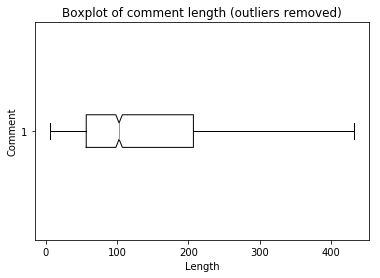

In [11]:
plt.boxplot(comments[comments['True_Length'] < 5000].True_Length,1,'',0)
plt.title("Boxplot of comment length (outliers removed)")
plt.ylabel("Comment")
plt.xlabel("Length");

In [12]:
print("Longest comment:  " + str(comments['True_Length'].max()) + " characters")
print("Shortest comment: " + str(comments['True_Length'].min()) + " characters")
print("Average:          " + str(round(comments.True_Length.mean())) + " characters")
print("Median:          " + str(round(comments.True_Length.median())) + " characters")

Longest comment:  13168 characters
Shortest comment: 6 characters
Average:          194 characters
Median:          103 characters


TypeError: 'AxesSubplot' object does not support indexing

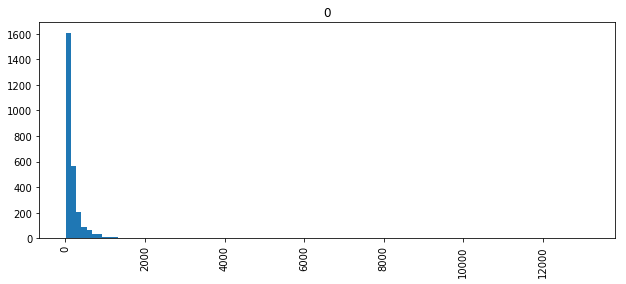

In [13]:
#experimenting, plotting length by whether its an insult or not
ax = comments.hist(column='True_Length',by ='Insult',bins=100,figsize = (10,4))
ax[0].set_xlim(0,2000)
ax[1].set_xlim(0,2000)
ax[0].set_ylim(0,3500)
ax[1].set_ylim(0,3500);

In [ ]:
ins = len(comments[comments['Insult'] == 1]) # number of insulting commments
non = len(comments[comments['Insult'] == 0]) # number of non-insulting comments
percents = [ins,non]

labels = 'Insulting', 'Non-Insulting'
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

plt.title("Percent of comments that are insulting")
plt.pie(percents, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=180);

# Common techniques for dealing with textual data

Text needs special preparation before using it for predictive modeling. Usually have to convert text to numbers in some way.

The most common way of working with textual data is to utilize the "Bag of Words" model. Each text segment gets split into words, and we count every time a word appears in each segment. Each word then gets assigned an integer ID. 

After transforming the text into a bag of words, there are various calculations and measurements that can be performed on the text.

- **Term frequency:** how many times a term appears in the texts
- **TF-IDF:** normalizes standard term frequency by taking into account how often words appear in general.
- **N-grams:** The traditional bag of words model preserves no spatial information, i.e. that certain words may follow each other. The n-gram model can be used to help remedy this, by storing words in groups of n. The basic bag of words model takes n=1, and thus is a 'unigram' model. Bigram models and above can help restore spatial information.

sklearn has some stuff:

- Convert text to word count vectors: **CountVectorizer**
- Convert text to word frequency vectors: **TfidfVectorizer**
- Convert text to unique integers: **HashingVectorizer**

Example of a standard (unigram) bag of words:

In [ ]:
vectorizer = CountVectorizer()
analyze = vectorizer.build_analyzer()

text = comments.iloc[9].Comment # load comment number 9
print(text,"\n")
print(analyze(text)) 

Example of bigrams: 

In [ ]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
analyze = bigram_vectorizer.build_analyzer()

text = comments.iloc[9].Comment # load comment number 9
print(text,"\n")
print(analyze(text)) 

Example counting word occurences: 

In [ ]:
vectorizer = CountVectorizer()

corpus = comments.Comment[8:10].as_matrix() # load comments 8 to 10
corpus = np.append(corpus,"you you you you you you you") # add a bunch of 'yous' to make counts obvious

print("Original documents:\n",corpus,"\n")
counts = vectorizer.fit_transform(corpus).toarray()
print("Dictionary of words:\n",vectorizer.get_feature_names(),"\n")
print("Word frequency from dictionary, per document:\n",counts)

# Potentially helpful commands I just want to remember

In [ ]:
comments['True_Length'].min() # finds the minimum value of specified column
comments['True_Length'].idxmin() # finds the index of the minimum value of specified column
comments[comments.True_Length < 2500].count().True_Length # search by some value and return the number matching
comments.isnull().sum().Date # count how many date fields have missing values
comments.Comment[5:10].as_matrix() # gets the comments from locs 5-10 as an array of strings

print("end")